In [1]:
import datetime
import time
#from datetime import datetime, time
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt 
import matplotlib
#matplotlib.style.use('ggplot')
import seaborn as sns
%pylab inline --no-import-all
#The old %matplotlib inline activates the inline backend, which renders figures in the notebook as static pngs.
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Contexte graphique de Seaborn
#sns.set_palette("Reds")
#sns.set_palette("Blues_d")
#sns.set(context='poster', palette='Reds')
sns.set(context='poster')

# Récupération des mesures des indicateurs Zabbix

## Paramètres principaux

In [3]:
# Accès
url = "http://metro-int.dsp-si.sncf.fr/api_jsonrpc.php"
login = "PYLS12691"
mdp = "2in8ie1D//07"

# Nom du "Host group" (Zabbix)
host_group_name = 'SHOS_INT'
# Sélection d'applications (de familles d'indicateurs)
sel_app = ['CPU', 'Garbage Collector', 'General Parameters', 'Memory', 'Memory Heaps', 'Memory Pools', 'Network interfaces', 'PostgreSQL', 'Processes', 'Security', 'Threads']

# Plage horaire pour l'extraction
# Les dates sont à indiquer en heure locale.
date1 = '2016-08-31 18:00:00'
date2 = '2016-09-01 08:00:00'

# Fichier csv de sortie des indicateurs et leurs mesures
csv_file = 'resultats_indicateurs.csv'

# Répertoire de sauvegarde des graphiques générés
#graph_dir = 'D:\\Users\\PYLS12691\\Documents\\2-Campagnes_en_cours\\CROSS-IR_SHOS\\batchs_qualif_20160811\\zabbix_graphs\\'
graph_dir = 'zabbix_graphs\\'

## Informations sur l'API de Zabbix

- https://www.zabbix.com/documentation/2.4/manual/api

## Configuration de l'accès à l'API Zabbix

In [4]:
headers = {'content-type': 'application/json'}

req_login = {
    "jsonrpc": "2.0",
    "method": "user.login",
    "params": {
        "user": login,
        "password": mdp
    },
    "id": 1
}

resp_login = requests.post(
        url, data=json.dumps(req_login), headers=headers).json()

resp_login

{'id': 1, 'jsonrpc': '2.0', 'result': 'eef139c9aa831bc5a85c1d379e71388e'}

In [5]:
token = resp_login['result']

In [6]:
## Définition de la plage horaire

# Prise en compte en datetime local
dt1 = pd.to_datetime(date1)
dt2 = pd.to_datetime(date2)

# Conversion en timestamp
ts1 = int(time.mktime(dt1.timetuple()))
ts2 = int(time.mktime(dt2.timetuple()))

[ts1, ts2]

[1472659200, 1472709600]

Test de conversion arrière :

In [7]:
# Dans ce sens, le timestamp est transformé en date - heure UTC.
pd.to_datetime(ts1, unit='s')

Timestamp('2016-08-31 16:00:00')

In [8]:
# Ici en heure locale !
pd.to_datetime(datetime.datetime.fromtimestamp(ts1))

Timestamp('2016-08-31 18:00:00')

## Récupération des groupes accessibles

In [9]:
req_group = {
    "jsonrpc": "2.0",
    "method": "hostgroup.get",
    "params": {
        "output": "extend",
    },
    "id": 1,
    "auth": token
}

resp_group = requests.post(
            url, data=json.dumps(req_group), headers=headers).json()

hg = pd.DataFrame(resp_group['result'])
hg

flags groupid internal      name
0     0     260        0  SHOS_INT

In [10]:
groupid = hg[ hg.name == host_group_name ].groupid
groupid

0    260
Name: groupid, dtype: object

## Récupération des hosts accessibles pour un groupe donné

In [11]:
req_host = {
    "jsonrpc": "2.0",
    "method": "host.get",
    "params": {
        "groupids": groupid.tolist(),
        "output": [
            "hostid",
            "host",
            "name"
        ],
        "selectInterfaces": [
            "interfaceid",
            "ip"
        ]
    },
    "id": 1,
    "auth": token
}

resp_host = requests.post(
            url, data=json.dumps(req_host), headers=headers).json()

hosts = pd.DataFrame(resp_host['result'])
hosts

host hostid                                         interfaces  \
0  u000odi11_hos_i  11213  [{'ip': '10.242.178.101', 'interfaceid': '1005'}]   
1        uhosbdi01  11145    [{'ip': '10.242.178.79', 'interfaceid': '938'}]   
2        u000odi11  11149   [{'ip': '10.242.178.101', 'interfaceid': '942'}]   

              name  
0  U000ODI11_HOS_I  
1        UHOSBDI01  
2        U000ODI11

## Récupération des applications accessibles pour chacun des hosts

In [12]:
# Les applications visibles ici (vu dans IHM)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CPU
# Filesystems
# General
# Memory
# Network interfaces
# OS
# Performance
# PostgreSQL
# PostgreSQL Table details
# Processes
# Security
# Zabbix agent

req_app = {
    "jsonrpc": "2.0",
    "method": "application.get",
    "params": {
        "output": "extend",
        "hostids": hosts.hostid.tolist(),
        "sortfield": "name"
    },
    "auth": token,
    "id": 1
}

resp_app = requests.post(
            url, data=json.dumps(req_app), headers=headers).json()

applications = pd.DataFrame(resp_app['result'])
applications

applicationid hostid                      name templateids
0           7447  11149                       CPU        [13]
1           7437  11145                       CPU        [13]
2           7438  11145               Filesystems         [5]
3           7448  11149               Filesystems         [5]
4           7719  11213         Garbage Collector       [599]
5           7449  11149                   General        [21]
6           7439  11145                   General        [21]
7           7720  11213        General Parameters       [600]
8           7450  11149                    Memory        [15]
9           7440  11145                    Memory        [15]
10          7721  11213              Memory Heaps       [601]
11          7722  11213              Memory Pools       [602]
12          7441  11145        Network interfaces         [7]
13          7451  11149        Network interfaces         [7]
14          7452  11149                        OS         [1]
15          7442  11145                        OS         [1]
16          7443  11145               Performance        [17]
17          7453  11149               Performance        [17]
18          7985  11145                PostgreSQL       [477]
19          7986  11145  PostgreSQL Table details       [478]
20          7444  11145                 Processes         [9]
21          7454  11149                 Processes         [9]
22          7445  11145                  Security        [23]
23          7455  11149                  Security        [23]
24          7723  11213                   Threads       [603]
25          7446  11145              Zabbix agent       [207]
26          7456  11149              Zabbix agent       [207]

## Récupération des indicateurs (monitored items)


In [13]:
#sel_app = ['Performance', 'PostgreSQL']
#sel_app = ['Performance']

In [14]:
# Identifiants des applications associées aux familles d'applications choisies
app_ids = []
for app in sel_app :
    app_ids.extend(applications.applicationid[applications.name == app].tolist())
#app_ids = app_ids.tolist()
app_ids

['7447',
 '7437',
 '7719',
 '7720',
 '7450',
 '7440',
 '7721',
 '7722',
 '7441',
 '7451',
 '7985',
 '7444',
 '7454',
 '7445',
 '7455',
 '7723']

In [15]:
# Récupération de tous les items accessibles
req_app_items = {
    "jsonrpc": "2.0",
    "method": "application.get",
    "params": {
        "applicationids": app_ids,
        "output": "extend",
        "selectItems": [
            "itemid",
            "name",
            "key_",
            "value_type" # A prendre en compte comme param history dans history.get
        ]
    },
    "id": 1,
    "auth": token
}

resp_app_items = requests.post(
            url, data=json.dumps(req_app_items), headers=headers).json()

#resp_app_items['result']
items = []
for a in resp_app_items['result'] :
    for i in a['items'] :
        i['applicationid'] = a['applicationid']
        i['hostid'] = a['hostid']
        items.append(i)
all_items = pd.DataFrame(items)
all_items

applicationid hostid  itemid  \
0            7719  11213  106176   
1            7719  11213  106177   
2            7719  11213  106178   
3            7719  11213  106179   
4            7720  11213  106152   
5            7720  11213  106147   
6            7720  11213  106151   
7            7720  11213  106162   
8            7720  11213  106164   
9            7720  11213  106165   
10           7720  11213  106167   
11           7720  11213  106168   
12           7720  11213  106169   
13           7720  11213  106170   
14           7720  11213  106171   
15           7721  11213  106148   
16           7721  11213  106149   
17           7721  11213  106153   
18           7721  11213  106156   
19           7721  11213  106157   
20           7721  11213  106154   
21           7721  11213  106155   
22           7721  11213  106158   
23           7721  11213  106159   
24           7721  11213  106163   
25           7721  11213  106166   
26           7721  11213  106160   
27           7721  11213  106161   
28           7437  11145  101116   
29           7437  11145  101117   
..            ...    ...     ...   
142          7985  11145  112505   
143          7985  11145  112506   
144          7985  11145  112507   
145          7985  11145  112520   
146          7985  11145  112521   
147          7985  11145  112509   
148          7985  11145  112515   
149          7985  11145  109862   
150          7985  11145  109853   
151          7985  11145  109857   
152          7985  11145  112518   
153          7985  11145  112519   
154          7985  11145  112512   
155          7985  11145  112516   
156          7985  11145  112517   
157          7985  11145  112514   
158          7985  11145  112513   
159          7985  11145  112524   
160          7985  11145  112525   
161          7985  11145  109847   
162          7985  11145  109848   
163          7985  11145  109849   
164          7985  11145  109845   
165          7985  11145  112511   
166          7985  11145  109855   
167          7985  11145  112522   
168          7985  11145  112523   
169          7985  11145  109854   
170          7985  11145  109850   
171          7985  11145  109861   

                                                  key_  \
0    zorka.jmx["java","java.lang:name=PS MarkSweep,...   
1    zorka.jmx["java","java.lang:name=PS Scavenge,t...   
2    zorka.jmx["java","java.lang:name=PS MarkSweep,...   
3    zorka.jmx["java","java.lang:name=PS Scavenge,t...   
4    zorka.jmx["java","java.lang:type=Compilation",...   
5                                         jvm.fdutil[]   
6    zorka.jmx["java","java.lang:type=ClassLoading"...   
7    zorka.jmx["java","java.lang:type=OperatingSyst...   
8    zorka.jmx["java","java.lang:type=OperatingSyst...   
9    zorka.jmx["java", "java.lang:type=OperatingSys...   
10   zorka.jmx["java","java.lang:type=OperatingSyst...   
11   zorka.jmx["java","java.lang:type=Runtime","Upt...   
12   zorka.jmx["java","java.lang:type=Runtime","VmN...   
13   zorka.jmx["java","java.lang:type=Runtime","VmV...   
14   zorka.jmx["java","java.lang:type=Runtime","VmV...   
15                     jvm.heaputil["HeapMemoryUsage"]   
16                  jvm.heaputil["NonHeapMemoryUsage"]   
17   zorka.jmx["java","java.lang:type=Memory","Heap...   
18   zorka.jmx["java","java.lang:type=Memory","Heap...   
19   zorka.jmx["java","java.lang:type=Memory","NonH...   
20   zorka.jmx["java","java.lang:type=Memory","Heap...   
21   zorka.jmx["java","java.lang:type=Memory","Heap...   
22   zorka.jmx["java","java.lang:type=Memory","NonH...   
23   zorka.jmx["java","java.lang:type=Memory","NonH...   
24   zorka.jmx["java","java.lang:type=OperatingSyst...   
25   zorka.jmx["java","java.lang:type=OperatingSyst...   
26   zorka.jmx["java","java.lang:type=Memory","NonH...   
27   zorka.jmx["java","java.lang:type=Memory","Obje...   
28                              system.cpu.util[,idle]   
29                             

## Récupération des mesures associées à tous ces indicateurs sur la période définie

In [16]:
# Récupération des mesures associées à tous ces indicateurs sur la période définie
#
# history.get : https://www.zabbix.com/documentation/2.4/manual/api/reference/history/get
#

monitors = pd.DataFrame()
bad_items = [] # On récupère les items n'ayant pas d'historique pour investigations éventuelles

for i in all_items.index :
#for i in [12,16]:
    req_history = {
        "jsonrpc": "2.0",
        "method": "history.get",
        "params": {
            "output": "extend",
            "itemids": all_items.loc[i].itemid,
            "sortfield": "clock",
            "sortorder": "ASC",
            "history": all_items.loc[i].value_type,
            #"limit": 10
            "time_from": ts1,
            "time_till": ts2
        },
        "auth": token,
        "id": 1
    }
    resp_history = requests.post(
            url, data=json.dumps(req_history), headers=headers).json()
    df_hist = pd.DataFrame(resp_history['result'])
    if df_hist.empty :
        bad_items.append([all_items.loc[i].itemid, all_items.loc[i].name, all_items.loc[i]['key_']])
    else :
        id_host = all_items.loc[i].hostid
        host_name = hosts[hosts.hostid == id_host].name.tolist()[0]
        item_key = all_items.loc[i]['key_']
        item_name = all_items.loc[i]['name']
        #column_name = "# " + host_name + " # " + item_name + " # " + item_key + " #"
        columns = [(host_name, item_name, item_key)]
        df = pd.DataFrame( data=df_hist.value.tolist(), 
                            index=pd.to_datetime( [ datetime.datetime.fromtimestamp(int(c)) for c in df_hist.clock.tolist() ] ), 
                            #columns=[column_name])
                            columns=pd.MultiIndex.from_tuples(columns))
        monitors = pd.concat([monitors, df])

monitors = monitors.sort_index()
monitors.index.names = ['datetime']
monitors.head()

U000ODI11                         \
                             Available memory            CPU $2 time   
                    vm.memory.size[available] system.cpu.util[,idle]   
datetime                                                               
2016-08-31 18:00:00                       NaN                    NaN   
2016-08-31 18:00:01                       NaN                    NaN   
2016-08-31 18:00:01                       NaN                    NaN   
2016-08-31 18:00:02                       NaN                    NaN   
2016-08-31 18:00:02                       NaN                    NaN   

                                                                          \
                                                                           
                    system.cpu.util[,interrupt] system.cpu.util[,iowait]   
datetime                                                                   
2016-08-31 18:00:00                         NaN                      NaN   
2016-08-31 18:00:01                         NaN                      NaN   
2016-08-31 18:00:01                         NaN                      NaN   
2016-08-31 18:00:02                         NaN                      NaN   
2016-08-31 18:00:02                         NaN                      NaN   

                                                                      \
                                                                       
                    system.cpu.util[,nice] system.cpu.util[,softirq]   
datetime                                                               
2016-08-31 18:00:00                    NaN                       NaN   
2016-08-31 18:00:01                    NaN                       NaN   
2016-08-31 18:00:01                    NaN                       NaN   
2016-08-31 18:00:02                    NaN                       NaN   
2016-08-31 18:00:02                    NaN                       NaN   

                                                                      \
                                                                       
                    system.cpu.util[,steal] system.cpu.util[,system]   
datetime                                                               
2016-08-31 18:00:00                     NaN                      NaN   
2016-08-31 18:00:01                     NaN                      NaN   
2016-08-31 18:00:01                     NaN                      NaN   
2016-08-31 18:00:02                     NaN                      NaN   
2016-08-31 18:00:02                     NaN                      NaN   

                                                                    \
                                           CPU nb of processor max   
                    system.cpu.util[,user]     system.cpu.num[max]   
datetime                                                             
2016-08-31 18:00:00                    NaN                     NaN   
2016-08-31 18:00:01                    NaN                     NaN   
2016-08-31 18:00:01                    NaN                     NaN   
2016-08-31 18:00:02                    NaN                     NaN   
2016-08-31 18:00:02                    NaN                     NaN   

                                                     ...                                   \
                                                     ...                                    
                                                     ...                                    
datetime                                             ...                                    
2016-08-31 18:00:00                                  ...                                    
2016-08-31 18:00:01                                  ...                                    
2016-08-31 18:00:01                                  ...                                    
2016-08-31 18:00:02                                  ...                                    
2016-08-31 18:00:02          

In [17]:
## Liste des indicateurs qui n'ont pu être récupérés
bad_items

[['106150', 96, 'jvm.memutil["{$PERM_GEN}"]'],
 ['106187',
  97,
  'zorka.jmx["java","java.lang:name=Code Cache,type=MemoryPool","CollectionUsage","used"]'],
 ['109852',
  129,
  'psql.idle_tx_connections[{$PGHOST},{$PGPORT},{$PGROLE},{$PGDATABASE}]'],
 ['109858',
  130,
  'psql.slow_dml_queries[{$PGHOST},{$PGPORT},{$PGROLE},{$PGDATABASE},{$PGSLOWQUERY_THRESHOLD}]'],
 ['112508',
  131,
  'psql.db_deadlocks[{$PGHOST},{$PGPORT},{$PGROLE},{$PGDATABASE},postgres]'],
 ['109843',
  132,
  'psql.active_connections[{$PGHOST},{$PGPORT},{$PGROLE},{$PGDATABASE}]'],
 ['109841',
  134,
  'logrt["{$PGLOGDIR}/postgresql-.*\\.log","PANIC|FATAL|ERROR|[Ee]rror"]'],
 ['109851',
  138,
  'psql.idle_connections[{$PGHOST},{$PGPORT},{$PGROLE},{$PGDATABASE}]'],
 ['109859',
  139,
  'psql.slow_queries[{$PGHOST},{$PGPORT},{$PGROLE},{$PGDATABASE},{$PGSLOWQUERY_THRESHOLD}]'],
 ['109860',
  140,
  'psql.slow_select_queries[{$PGHOST},{$PGPORT},{$PGROLE},{$PGDATABASE},{$PGSLOWQUERY_THRESHOLD}]'],
 ['112520',
  145,


Ecriture des résultats dans le fichier csv défini :

In [18]:
monitors.to_csv(csv_file, sep = ';')

# Génération des graphiques des mesures Zabbix

In [19]:
# Fichier csv de sortie des indicateurs et leurs mesures
monitors = pd.read_csv(csv_file, sep = ';', header=[0,1,2], index_col=0)
monitors.head()

D:\Users\PYLS12691\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2705: DtypeWarning: Columns (36,48,50,51,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


U000ODI11                         \
                             Available memory            CPU $2 time   
                    vm.memory.size[available] system.cpu.util[,idle]   
datetime                                                               
2016-08-31 18:00:00                       NaN                    NaN   
2016-08-31 18:00:01                       NaN                    NaN   
2016-08-31 18:00:01                       NaN                    NaN   
2016-08-31 18:00:02                       NaN                    NaN   
2016-08-31 18:00:02                       NaN                    NaN   

                                                                          \
                                                                           
                    system.cpu.util[,interrupt] system.cpu.util[,iowait]   
datetime                                                                   
2016-08-31 18:00:00                         NaN                      NaN   
2016-08-31 18:00:01                         NaN                      NaN   
2016-08-31 18:00:01                         NaN                      NaN   
2016-08-31 18:00:02                         NaN                      NaN   
2016-08-31 18:00:02                         NaN                      NaN   

                                                                      \
                                                                       
                    system.cpu.util[,nice] system.cpu.util[,softirq]   
datetime                                                               
2016-08-31 18:00:00                    NaN                       NaN   
2016-08-31 18:00:01                    NaN                       NaN   
2016-08-31 18:00:01                    NaN                       NaN   
2016-08-31 18:00:02                    NaN                       NaN   
2016-08-31 18:00:02                    NaN                       NaN   

                                                                      \
                                                                       
                    system.cpu.util[,steal] system.cpu.util[,system]   
datetime                                                               
2016-08-31 18:00:00                     NaN                      NaN   
2016-08-31 18:00:01                     NaN                      NaN   
2016-08-31 18:00:01                     NaN                      NaN   
2016-08-31 18:00:02                     NaN                      NaN   
2016-08-31 18:00:02                     NaN                      NaN   

                                                                    \
                                           CPU nb of processor max   
                    system.cpu.util[,user]     system.cpu.num[max]   
datetime                                                             
2016-08-31 18:00:00                    NaN                     NaN   
2016-08-31 18:00:01                    NaN                     NaN   
2016-08-31 18:00:01                    NaN                     NaN   
2016-08-31 18:00:02                    NaN                     NaN   
2016-08-31 18:00:02                    NaN                     NaN   

                                                     ...                                   \
                                                     ...                                    
                                                     ...                                    
datetime                                             ...                                    
2016-08-31 18:00:00                                  ...                                    
2016-08-31 18:00:01                                  ...                                    
2016-08-31 18:00:01                                  ...                                    
2016-08-31 18:00:02                                  ...                                    
2016-08-31 18:00:02          

## Génération des graphes associés à chacun des indicateurs

In [20]:
for col in monitors.columns :
    graph_values = pd.Series(monitors[col]).dropna()
    if not(graph_values.empty) and type(graph_values[0]) != str :
        graph_title = '[' + col[0] + '] - ' + col[1] + ', ' + col[2]
        #graphe_title = graphe_title.translate ({ord(c): "_" for c in "!@#^&*(){};:,/<>?\|`~-=+"})
        graph_title = graph_title.translate({ord(c): "_" for c in ":/\""})
        #plt.figure()
        graph_values.plot(title = graph_title, figsize=(14, 5))
        plt.xticks(rotation=10)
        plt.savefig(graph_dir + graph_title + '.png')
        plt.close()

## Génération des graphes indicateurs communs aux serveurs

D:\Users\PYLS12691\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


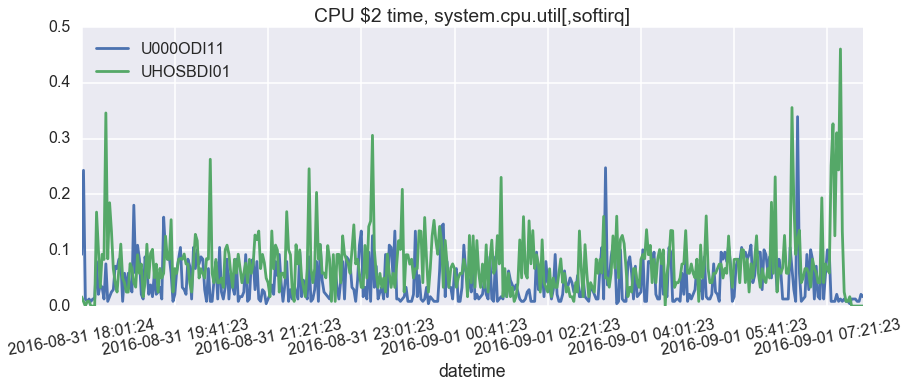

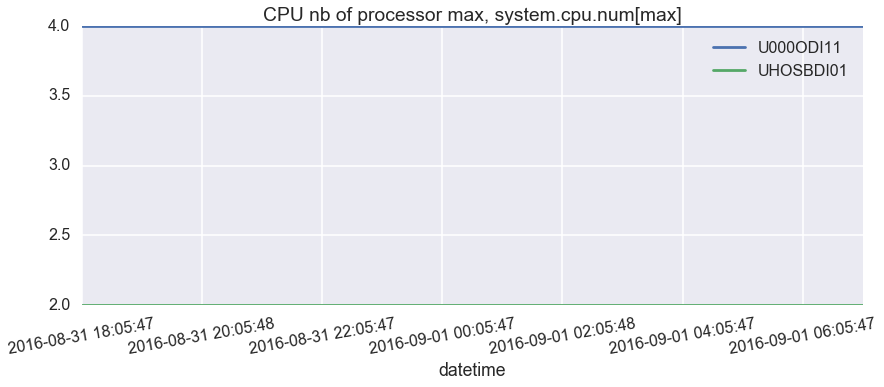

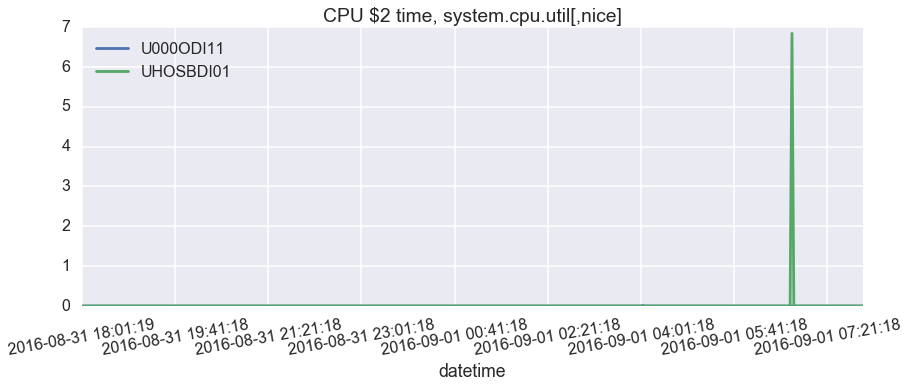

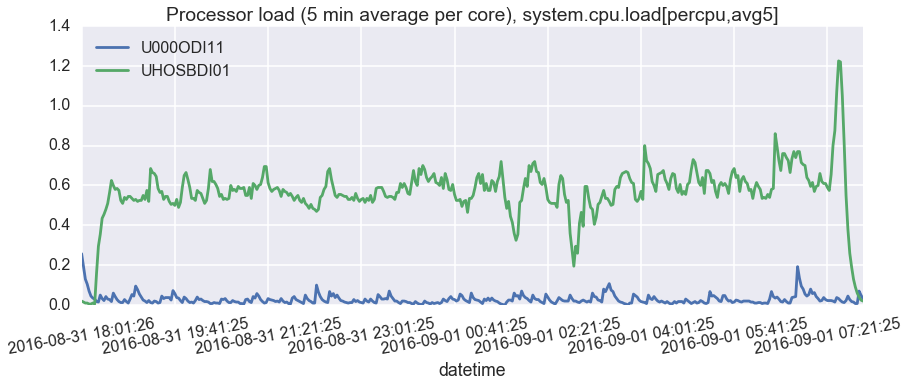

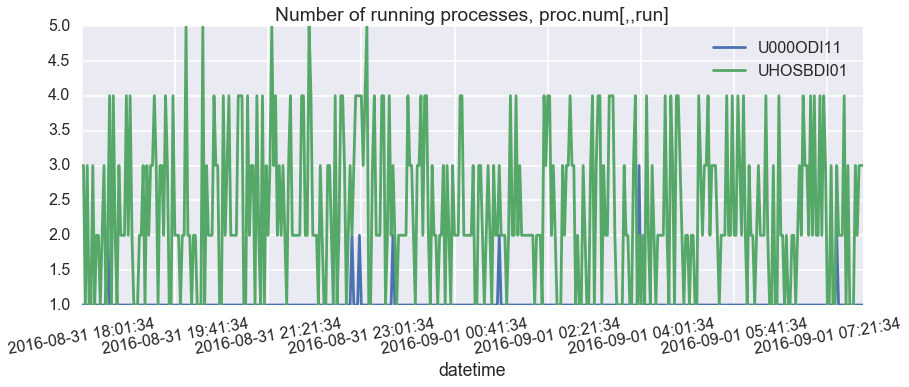

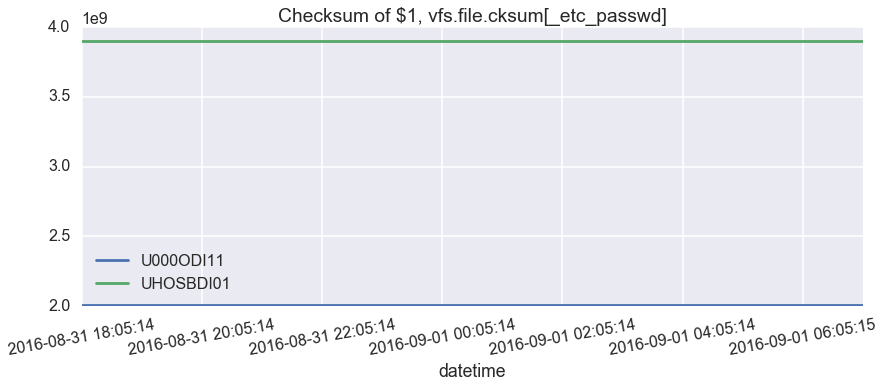

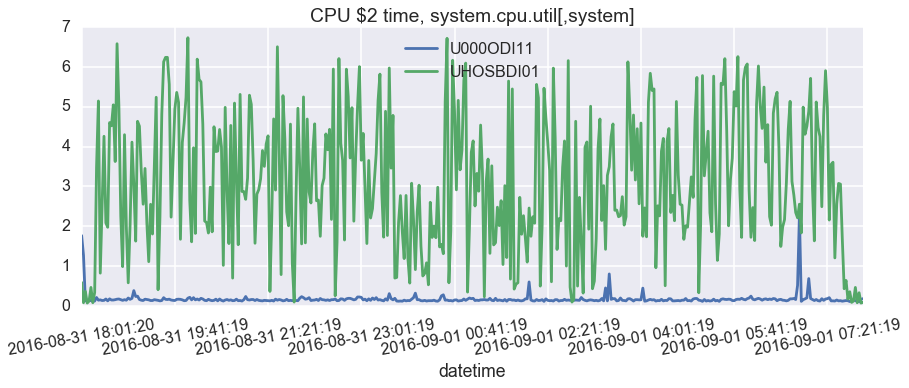

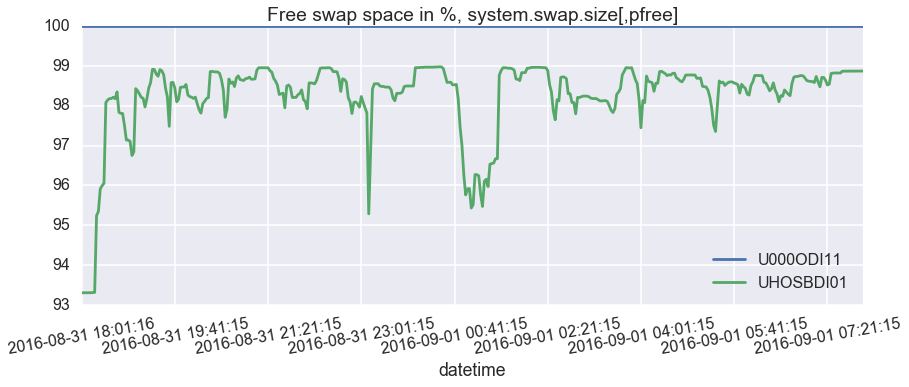

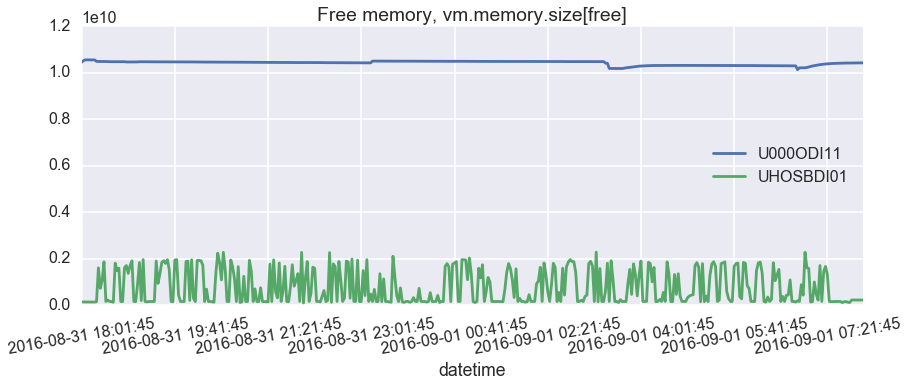

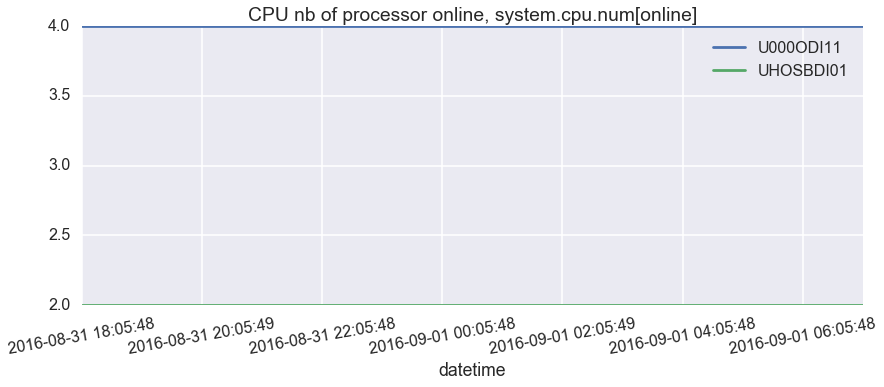

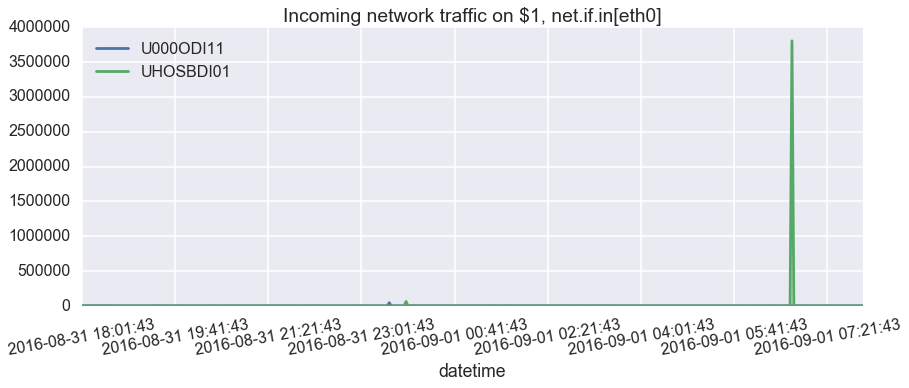

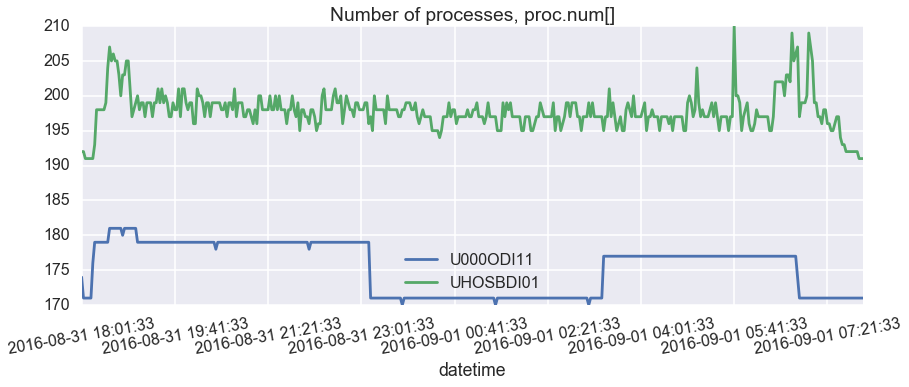

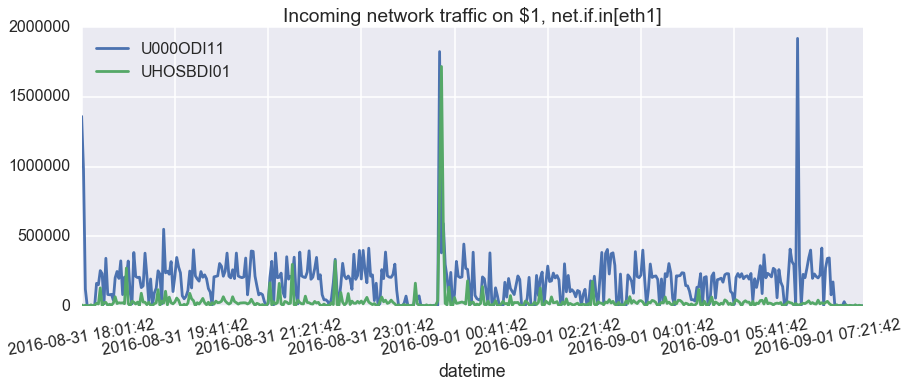

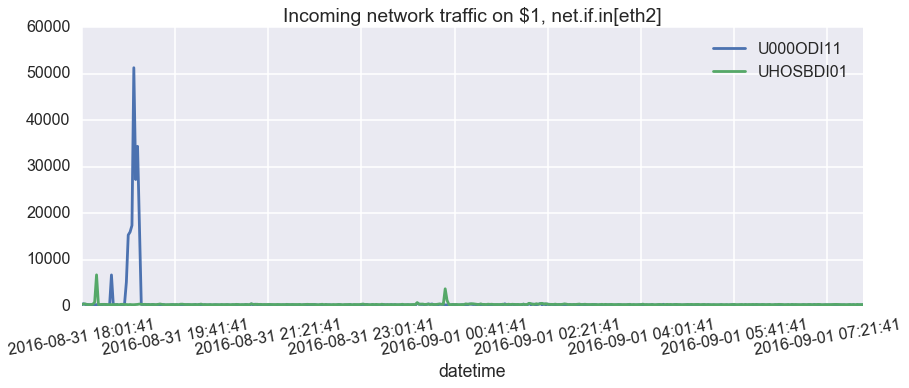

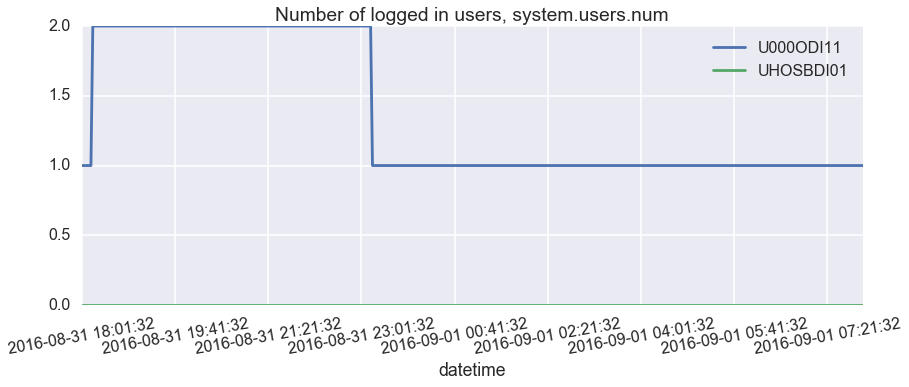

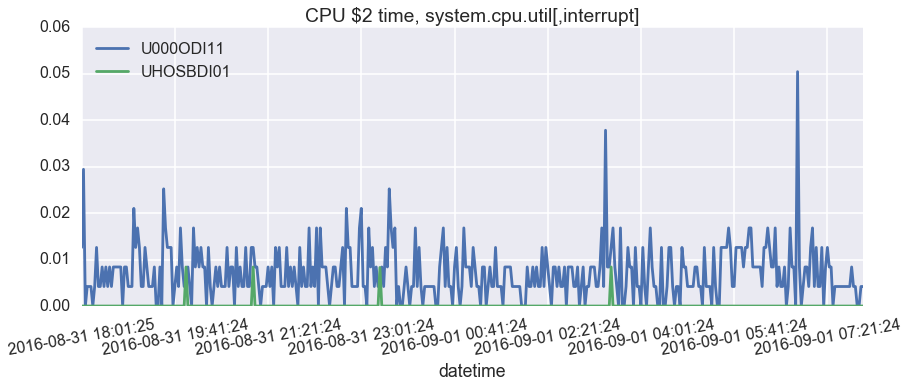

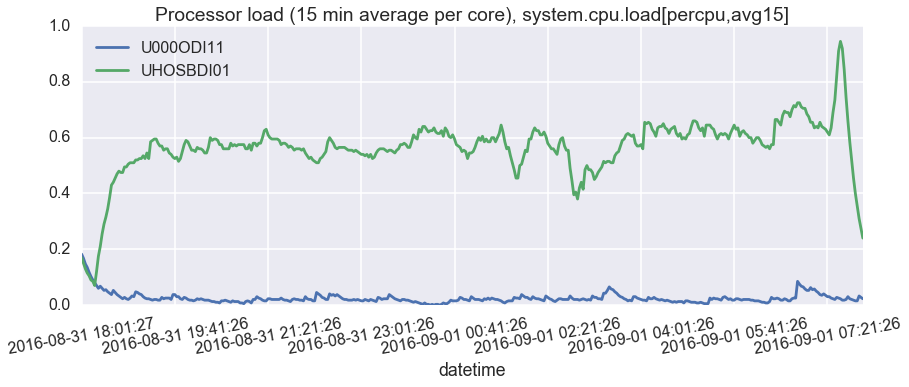

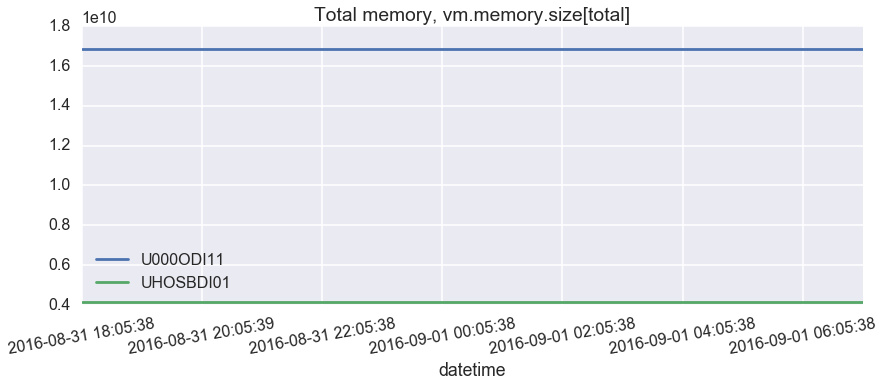

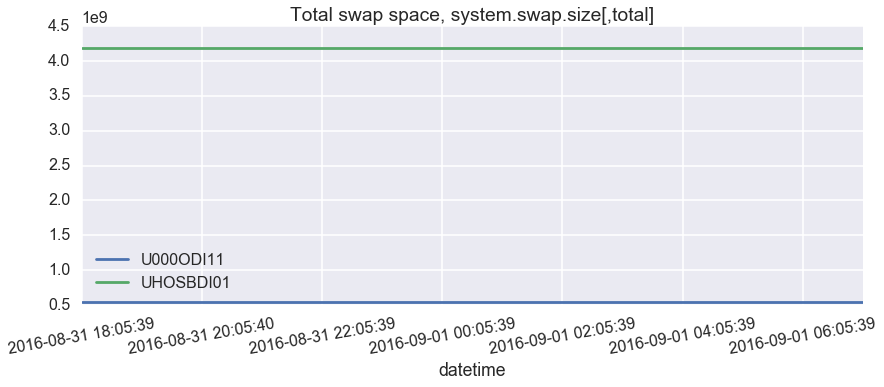

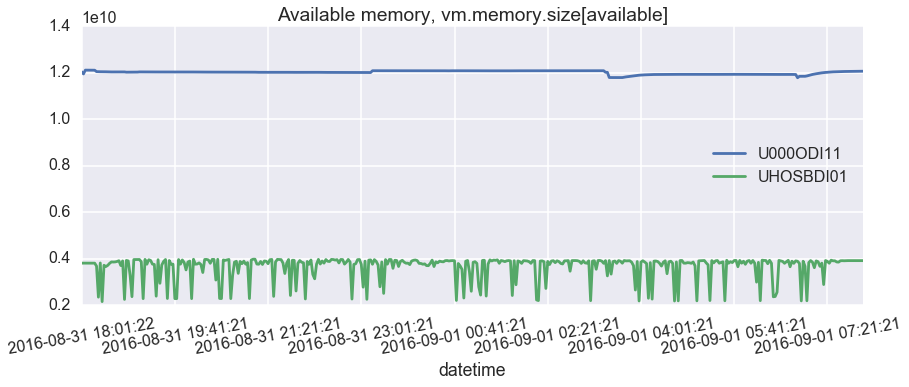

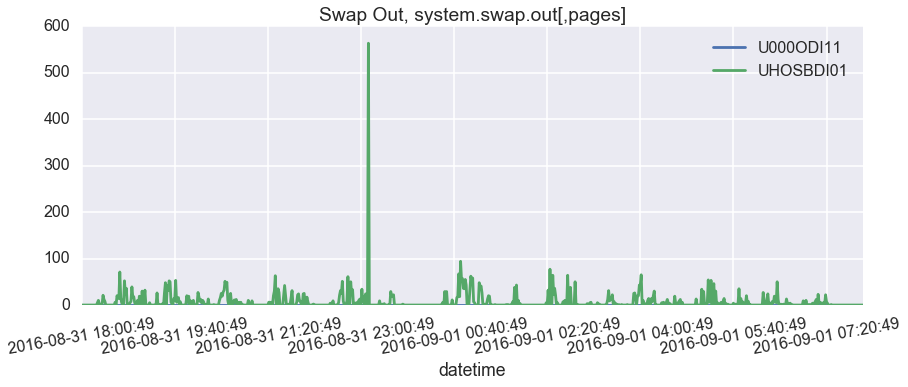

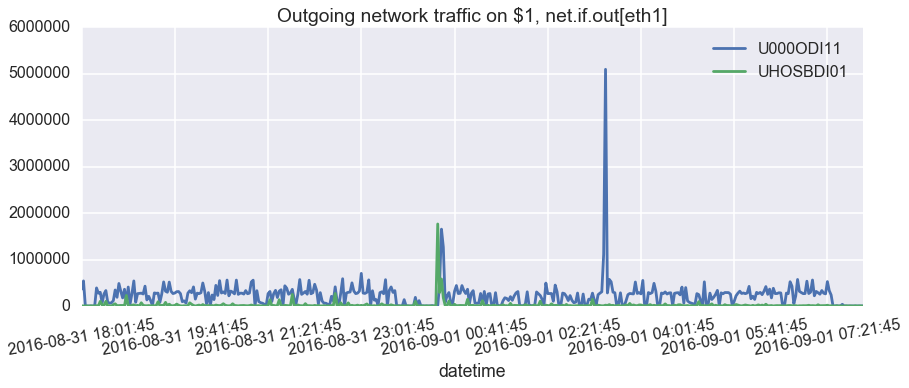

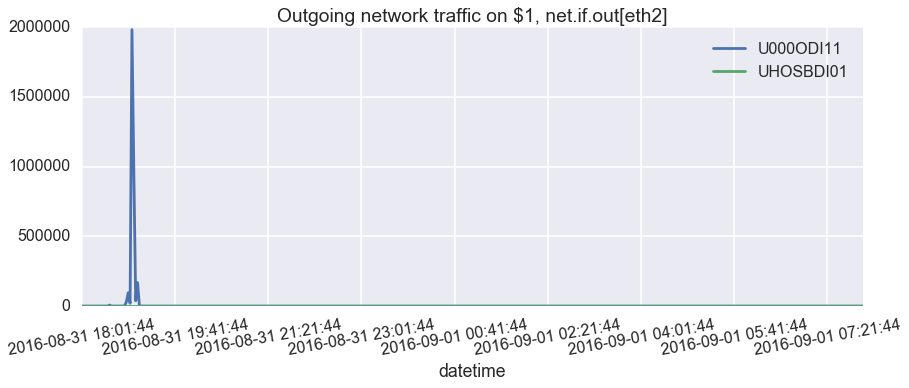

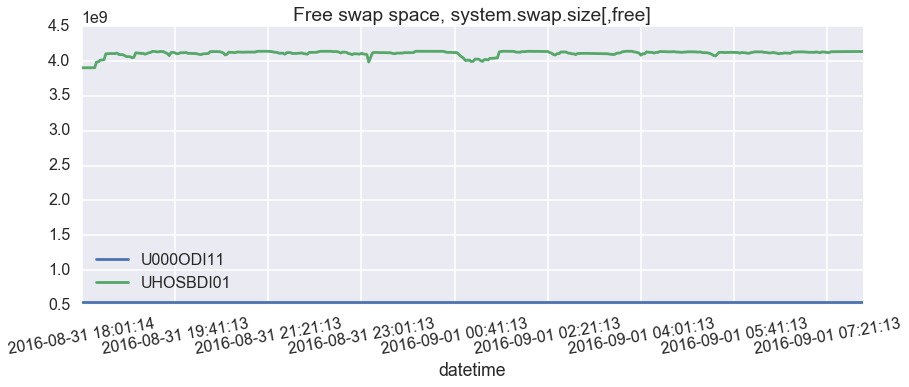

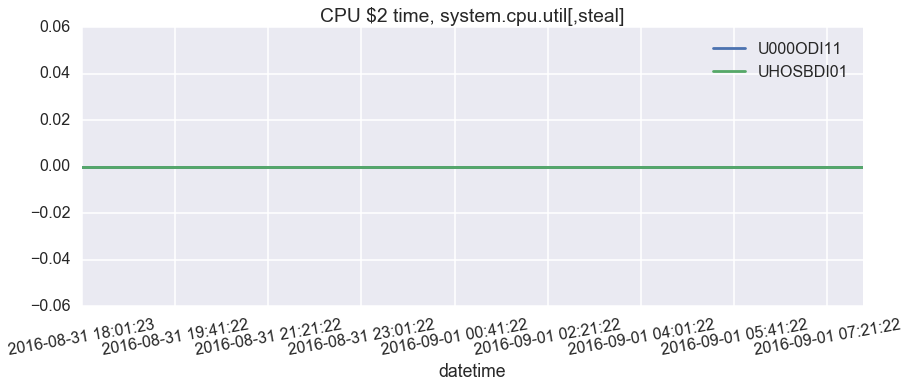

In [21]:
# Détermination des indicateurs portant sur plusieurs hosts
items = {}
for col in monitors.columns :
    if col[2] in items.keys() :
        items[col[2]].append(col)
    else :
        items[col[2]] = [col]
    
mult_items = []
for k in items.keys() :
    if len(items[k]) > 1 :
        mult_items.append(items[k])
        
# Génération des graphiques sur les indicateurs portant sur plusieurs serveurs
for mi in mult_items :
    fig = plt.figure()
    legends = [col[0] for col in mi]
    for col in mi :
        graph_values = pd.Series(monitors[col]).dropna()
        graph_title = col[1] + ', ' + col[2]
        graph_title = graph_title.translate({ord(c): "_" for c in ":/\""})
        graph_values.plot(title = graph_title, label=col[0], figsize=(14, 5))
    plt.xticks(rotation=10)
    plt.legend(legends, loc = 'best')
    plt.savefig(graph_dir + graph_title + '.png')
    #plt.savefig(graph_dir + graph_title + '.svg')
    #plt.close()